# Setup

In [1]:
from pathlib import Path

import kuzu
import pandas as pd

import graph.visualization as vis
from shared.settings import LOCAL_DIR, env

In [2]:
db_path = Path(LOCAL_DIR) / env.str("ECON_COMP_GRAPH_DB")
assert db_path.exists(), "You need to create the graph DB using dlctl first"

In [3]:
db = kuzu.Database(db_path)
conn = kuzu.Connection(db)

# Analysis

## Top 10 Dominating Economies

In [4]:
result = conn.execute(
    """
    MATCH (c:Country)
    RETURN c, c.country_name_short AS country
    ORDER BY c.con_score DESC
    LIMIT 10
    """
)

In [5]:
dom_econ_df = result.get_as_df()[["country"]]
dom_econ_df.index = pd.RangeIndex(start=1, stop=len(dom_econ_df) + 1, name="rank")
dom_econ_df

,country
rank,
1,United States of America
2,Canada
3,United Arab Emirates
4,Netherlands
5,United Kingdom
6,Belgium
7,Italy
8,Spain
9,France


### Top 3 Exports

In [6]:
result = conn.execute(
    """
    MATCH (c:Country)
    WITH c AS c
    ORDER BY c.con_score DESC
    LIMIT 10

    MATCH (c)-[e:Exports]->(p:Product)
    WITH p AS p, c AS c, e AS e
    ORDER BY e.amount_usd DESC
    LIMIT 20

    WITH p AS p,
        collect({ source: c, rel: e }) AS exports,
        count(DISTINCT c) AS n_countries
    WHERE n_countries > 1

    UNWIND exports AS e
    RETURN e.source AS country, e.rel AS exports, p AS product
    """
)

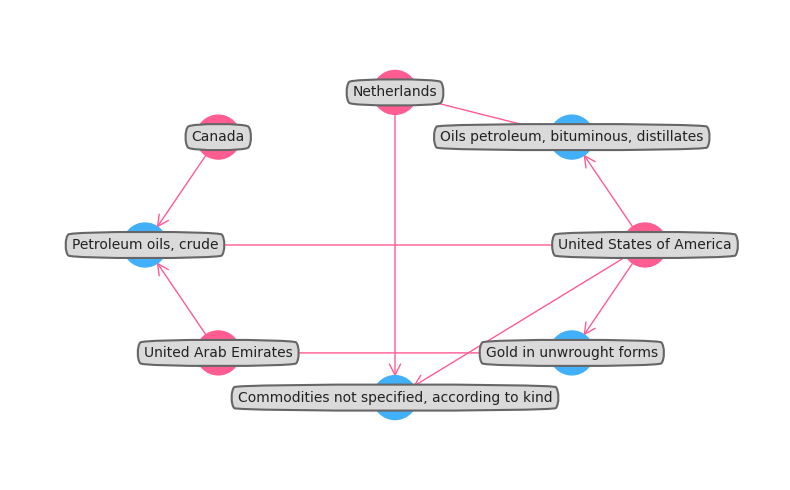

In [7]:
dom_econ_g = result.get_as_networkx()

for node, data in dom_econ_g.nodes(data=True):
    match data["_label"]:
        case "Country":
            data["label"] = data["country_name_short"]
        case "Product":
            data["label"] = data["product_name_short"]

vis.plot(dom_econ_g)